In [2]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [3]:
notebooks = os.path.abspath('')
src = os.path.dirname(notebooks)
if not src in sys.path: 
    sys.path.append(src)

In [4]:
from helpers import get_emotion_abrs_from_ids

# Paths

In [5]:
output_path = '../../files/out/video/'
# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [6]:
exec(open(glob_conf_path).read())

# Load and shuffle data

In [7]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(output_path + 'video_data_intensity_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,video_id,emotion_1_id,group
265,A200_reg_p_3,0.463187,0.749064,0.0,0.000000,0.203252,0.203252,0.188679,0.702141,0.733587,...,0.224003,0.199766,0.0,0.000000,0.171355,0.171355,0.650,A200,0,0
74,A102_awe_p_3,0.175606,0.933978,0.0,0.333333,0.056911,0.056911,0.056604,0.382604,0.703252,...,0.310979,0.467789,0.0,0.166667,0.084399,0.084399,0.100,A102,18,1
148,A18_awe_v_1,0.188274,0.492815,0.0,0.000000,0.198374,0.198374,0.075472,0.190862,0.426560,...,0.207909,0.572976,0.0,0.333333,0.020460,0.020460,0.025,A18,18,1
3,A101_awe_p_4,0.061996,0.400991,0.0,0.000000,0.060976,0.060976,0.358491,0.065202,0.477737,...,0.046476,0.181229,0.0,0.000000,0.031714,0.031714,0.550,A101,18,0
233,A200_dou_p_2,0.182025,0.409290,0.0,0.000000,0.178049,0.178049,0.245283,0.200819,0.541570,...,0.226453,0.214635,0.0,0.000000,0.173913,0.173913,0.175,A200,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,A101_env_p_1,0.030968,0.449200,0.0,0.166667,0.029268,0.029268,0.132075,0.096300,0.376929,...,0.308084,0.515232,0.0,0.166667,0.054220,0.054220,0.025,A101,4,0
240,A200_env_p_2,0.102112,0.580680,0.0,0.333333,0.069106,0.069106,0.150943,0.038659,0.353450,...,0.295423,0.313167,0.0,0.000000,0.165217,0.165217,0.100,A200,4,0
31,A101_env_v_4,0.168026,0.816701,0.0,0.166667,0.046341,0.046341,0.094340,0.233069,0.599587,...,0.283891,0.740826,0.0,0.166667,0.021483,0.021483,0.125,A101,4,0
184,A18_gui_p_1,0.146868,0.699797,0.0,0.333333,0.089431,0.089431,0.037736,0.118299,0.550872,...,0.239968,0.380419,0.0,0.333333,0.084399,0.084399,0.075,A18,40,1


# Other functions

In [13]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [14]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [15]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_conf_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [16]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [17]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Training and testing

### Get X, y and groups from the training data set

In [8]:
# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())

# Elastic Net SGD Classifier

### Grid Search best parameters

In [10]:
from sklearn.linear_model import SGDClassifier

# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 960 candidates, totalling 1920 fits
SGDClassifier(alpha=0.01, class_weight='balanced', l1_ratio=0.55, loss='log',
              max_iter=2500, n_iter_no_change=20, penalty='elasticnet',
              random_state=27)


In [11]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,param_penalty,param_random_state,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
680,0.130757,0.003392,0.105517,0.010653,0.01,balanced,0.55,log,2500,20,elasticnet,27,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.614603,0.634820,0.624712,0.010108,1
681,0.269466,0.032772,0.097468,0.011323,0.01,balanced,0.55,log,2500,50,elasticnet,27,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.614119,0.633789,0.623954,0.009835,2
704,0.123180,0.011694,0.092448,0.006788,0.01,balanced,0.85,log,2500,20,elasticnet,27,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.616457,0.631239,0.623848,0.007391,3


### Cross validate with best parameters

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


printing Area Under the Curve (AUC) measures
AUC_avg (train): 0.9095857538728631
AUC_std (train): 0.00019072182158114126
AUC_avg (validation): 0.6247116219284189
AUC_std (validation): 0.010108256543803318
printing Unweighted Average Recall (UAC) measures
UAR_avg (train): 0.5858796296296296
UAR_std (train): 0.009490740740740744
UAR_avg (validation): 0.24375000000000002
UAR_std (validation): 0.006249999999999992


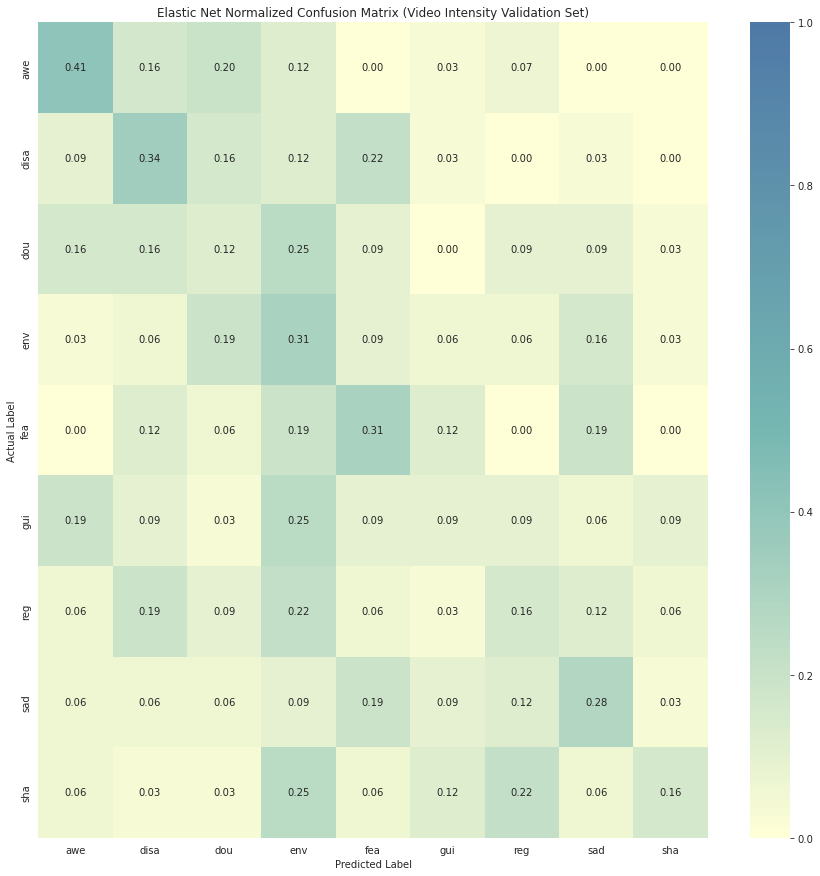

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

logo = LeaveOneGroupOut()

# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

# get scores
scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('printing Area Under the Curve (AUC) measures')
print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True
                       )
      
print('printing Unweighted Average Recall (UAC) measures')
print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Elastic Net Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_elastic_net_intensity_video.svg')


# kNN Classifier

TODO: Might be smart to seed such that every emotion has it's own cluster starting point

In [19]:
# we want to evaluate different number of neighbors (clusters) based on the size of the training set. 
# set a cluster floor at the number of targets 
floor = len(y.unique())
# set a cluster cap equal to 3/4:ths of the size of the training set.
# size of training set is equal to all datapoints minus the size of one group
cap = (len(y) - groups.value_counts().max()) * 3/4

n_neigh_values   = np.linspace(floor, cap, 50, dtype=np.int64).tolist()

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Define other to evaluate
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 450 candidates, totalling 900 fits
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     n_jobs=-1, n_neighbors=21)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


AUC_avg (train): 0.8524355445986305
AUC_std (train): 0.004253908526369421
AUC_avg (validation): 0.5999810871637044
AUC_std (validation): 8.944235018448765e-05
UAR_avg (train): 0.4525462962962963
UAR_std (train): 0.0219907407407407
UAR_avg (validation): 0.1877314814814815
UAR_std (validation): 0.006712962962962962


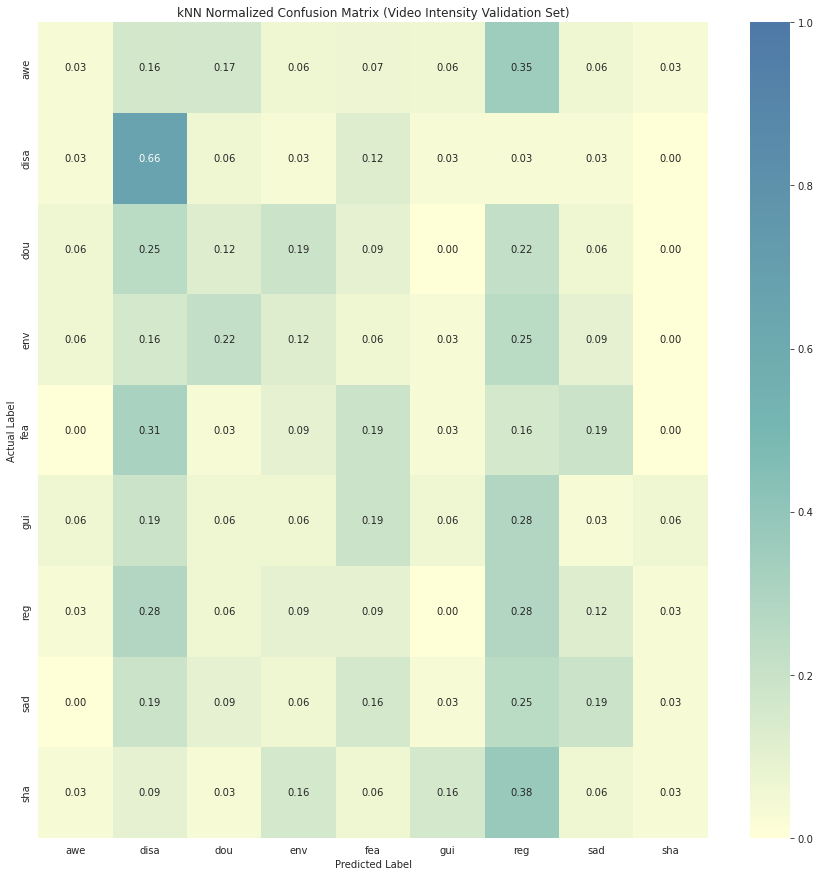

In [21]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='kNN Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_knn_intensity_video.svg')

## Decision Tree


In [22]:
from sklearn.tree import DecisionTreeClassifier

# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features=70, min_samples_leaf=0.1,
                       min_samples_split=0.4, random_state=27,
                       splitter='random')


In [23]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_class_weight,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
1615,0.009472,0.000545,0.107108,0.002679,random,27,0.4,0.1,70,15,entropy,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.610113,0.598145,0.604129,0.005984,1
619,0.012277,0.000652,0.091259,0.001273,best,27,0.2,0.1,77,20,gini,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.604517,0.586182,0.595349,0.009168,2
3570,0.014015,0.000404,0.112432,0.007703,best,27,0.1,0.1,77,10,gini,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.604517,0.586182,0.595349,0.009168,2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


AUC_avg (train): 0.7363296425796426
AUC_std (train): 0.0023886703574203527
AUC_avg (validation): 0.6041285374781469
AUC_std (validation): 0.005984006228146821
UAR_avg (train): 0.2534722222222222
UAR_std (train): 0.00347222222222221
UAR_avg (validation): 0.20162037037037037
UAR_std (validation): 0.020601851851851843


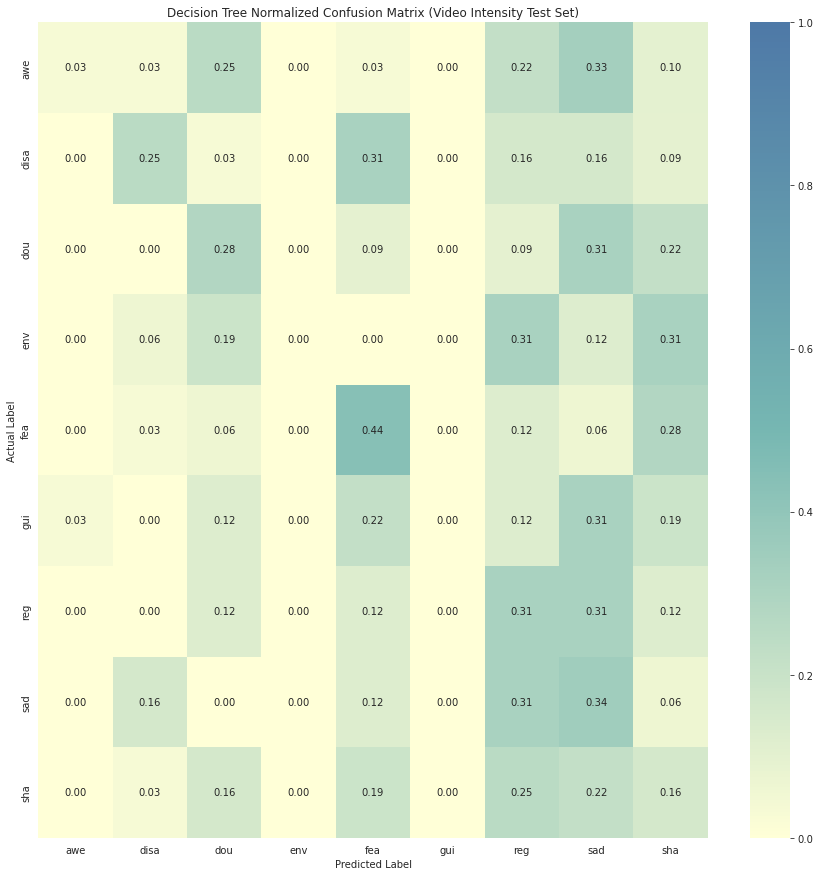

In [24]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Decision Tree Normalized Confusion Matrix (Video Intensity Test Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_tree_intensity_video.svg')

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Define parameters to evaluate
# the number of trees to build before taking the maximum voting or averages of predictions
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4320 is smaller than n_iter=5000. Running 4320 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 4320 candidates, totalling 8640 fits
RandomForestClassifier(class_weight='balanced', max_depth=60,
                       max_features='sqrt', min_samples_leaf=2,
                       n_estimators=282, n_jobs=-1, random_state=27)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


AUC_avg (train): 1.0
AUC_std (train): 0.0
AUC_avg (validation): 0.6448014550553612
AUC_std (validation): 0.00124676755536135


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished


UAR_avg (train): 1.0
UAR_std (train): 0.0
UAR_avg (validation): 0.23032407407407407
UAR_std (validation): 0.028935185185185175


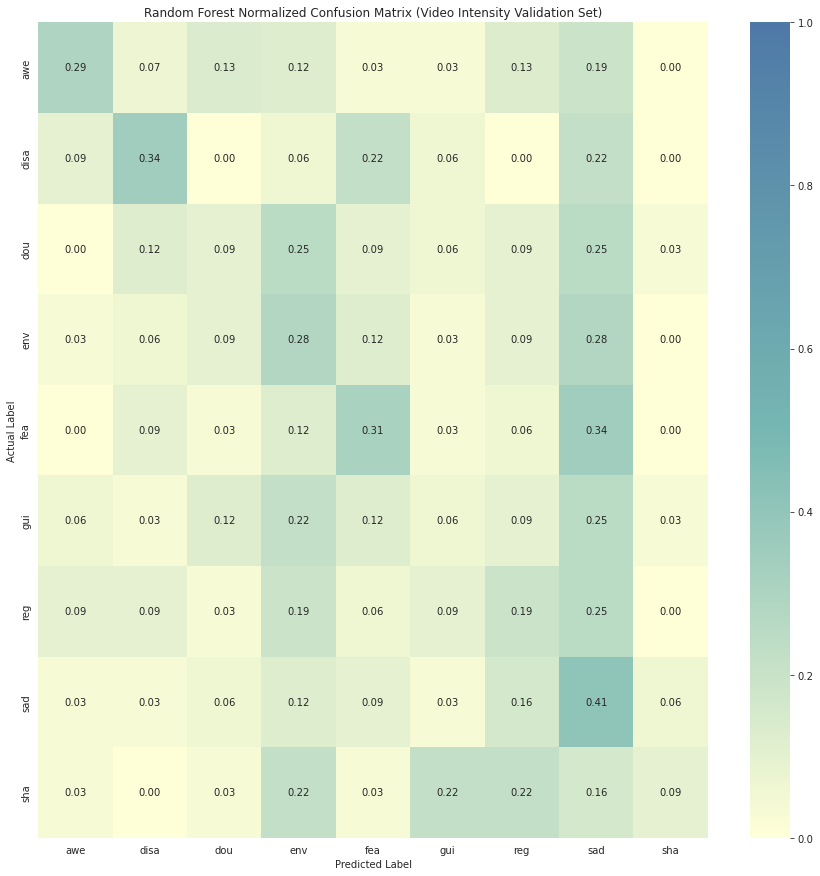

In [26]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Random Forest Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_rf_intensity_video.svg')